In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  #显示中文
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) # 显示所有列
from tqdm import tqdm
import geopandas as gpd
import transbigdata as tbd
import geoplot as gplt

In [2]:
trip_data = pd.read_csv('../trip_data_3_7.csv')
trip_data['starttime'] = pd.to_datetime(trip_data['starttime'])
trip_data['endtime'] = pd.to_datetime(trip_data['endtime'])
trip_data['bikeid'] = trip_data['bikeid'].astype(str)
print('数据：',trip_data.shape)
(trip_data.sort_values(by=['bikeid','starttime'],inplace=True))
print('车辆数量：',trip_data['bikeid'].nunique())
trip_data.info()

数据： (700555, 8)
车辆数量： 132061
<class 'pandas.core.frame.DataFrame'>
Int64Index: 700555 entries, 264963 to 391970
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   bikeid     700555 non-null  object        
 1   starttime  700555 non-null  datetime64[ns]
 2   startlng   700555 non-null  float64       
 3   startlat   700555 non-null  float64       
 4   endtime    700555 non-null  datetime64[ns]
 5   endlng     700555 non-null  float64       
 6   endlat     700555 non-null  float64       
 7   distance   700555 non-null  float64       
dtypes: datetime64[ns](2), float64(5), object(1)
memory usage: 48.1+ MB


In [3]:
# 生成出行次数的分布数据
trip_distribution = ((trip_data.groupby(by='bikeid', as_index=True).agg(
    {'startlng': 'count'})).rename(columns={'startlng': 'trip_num'})).reset_index(drop=False)
# 出行时刻的分布
trip_data['O_time'] = trip_data.apply(lambda x : x['starttime'].hour ,axis=1)

# 出行时长
trip_data['duration'] = (trip_data['endtime'] - trip_data['starttime']).dt.seconds / 60
# 出行距离
trip_data['trip_distance']=trip_data.apply(lambda x:tbd.getdistance(x['endlng'], x['endlat'], x['startlng'], x['startlat'])/1000,axis=1)
# 曼哈顿距离
cos_lat = np.cos(30.656883854354138/180 * np.pi) * 111000  # 米
def mhd_dis(lng1, lat1, lng2, lat2):
    lng_dis = cos_lat * abs(lng1-lng2)
    lat_dis = 111000 * abs(lat1-lat2)
    return lng_dis + lat_dis

trip_data['mhd_trip_distance']=trip_data.apply(lambda x:mhd_dis(x['endlng'], x['endlat'], x['startlng'], x['startlat'])/1000,axis=1)

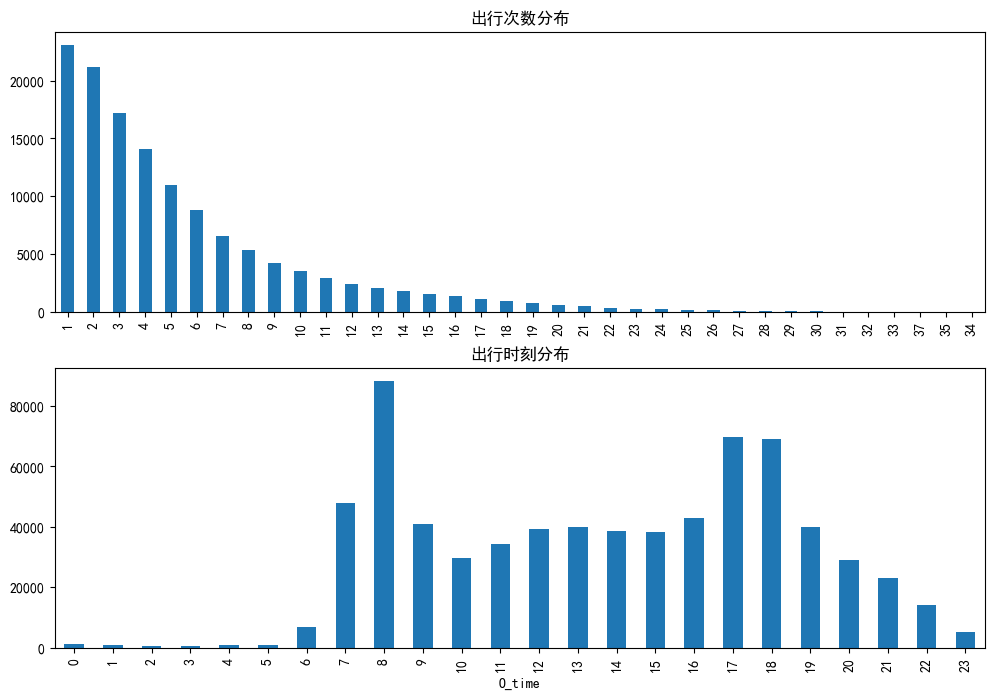

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))  # 可使用GridSpec用法
(trip_distribution['trip_num'].value_counts()).plot.bar(ax=ax1)
ax1.set_title('出行次数分布')
(trip_data.groupby(by='O_time').count())['bikeid'].plot.bar(ax=ax2)
ax2.set_title('出行时刻分布')
plt.show()

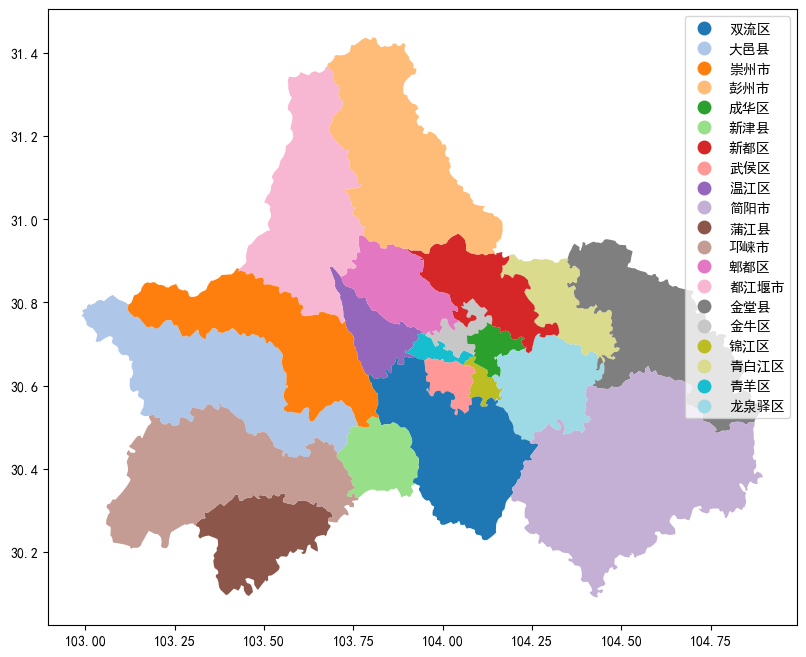

In [66]:
cd = gpd.read_file('E:/Data/成都数据/chengdu_shp/chengdu_distric.shp')
fig, ax = plt.subplots(1,1,figsize=(12, 8)) # 可使用GridSpec用法
cd.plot(ax=ax,column='NAME',legend=True,cmap='tab20')
plt.show()

In [7]:
gdf_trip_data = (gpd.GeoDataFrame(data=trip_data,geometry=gpd.points_from_xy(trip_data['endlng'],trip_data['endlat']))).clip(mask=cd)

In [8]:
gdf_trip_data.sort_values(by='trip_distance',ascending=False).head(10)

,bikeid,starttime,startlng,startlat,endtime,endlng,endlat,distance,O_time,duration,trip_distance,geometry
39762,8620291124,2018-03-07 08:24:46,104.031120,30.673974,2018-03-07 08:37:00,103.662080,31.000459,0.000,8,12.233333,50.590254,POINT (103.66208 31.00046)
350396,286597236,2018-03-07 13:17:51,104.077990,30.590373,2018-03-07 13:31:18,104.481867,30.555389,0.000,13,13.450000,38.861119,POINT (104.48187 30.55539)
544294,286713007,2018-03-07 17:06:13,104.187074,30.689055,2018-03-07 17:08:33,103.826001,30.711713,0.420,17,2.333333,34.614294,POINT (103.82600 30.71171)
413770,286551804,2018-03-07 15:15:48,104.186882,30.652367,2018-03-07 15:20:08,103.843096,30.699472,0.000,15,4.333333,33.292627,POINT (103.84310 30.69947)
413766,8642502329,2018-03-07 07:56:23,104.186882,30.652367,2018-03-07 08:05:50,103.842618,30.693711,0.000,7,9.450000,33.244056,POINT (103.84262 30.69371)
413769,286510064,2018-03-07 21:53:08,104.186882,30.652367,2018-03-07 21:59:04,103.852515,30.694287,0.000,21,5.933333,32.316006,POINT (103.85251 30.69429)
206848,8640178991,2018-03-07 10:32:06,103.976831,30.746353,2018-03-07 10:40:11,104.231528,30.575546,0.510,10,8.083333,30.890520,POINT (104.23153 30.57555)
405939,286705556,2018-03-07 08:14:58,103.946588,30.656318,2018-03-07 08:23:16,104.058940,30.406107,0.409,8,8.300000,29.830689,POINT (104.05894 30.40611)
405940,286705556,2018-03-07 11:05:12,103.946565,30.656462,2018-03-07 11:13:05,104.046925,30.405373,4.277,11,7.883333,29.528141,POINT (104.04693 30.40537)
451691,8640246041,2018-03-07 15:28:50,104.080401,30.653416,2018-03-07 15:34:19,104.162536,30.399007,0.987,15,5.483333,29.362471,POINT (104.16254 30.39901)


+ 原始distance计算的速度符合共享单车报告的均速  
+ 使用曼哈顿距离  
```scipy```

In [101]:
road = gpd.read_file('E:/Data/成都数据/成都道路/chengdu_road(未简化)/edges.shp')
node = gpd.read_file('E:/Data/成都数据/成都道路/chengdu_road(未简化)/nodes.shp')

In [ ]:
from scipy.spatial import cKDTree

node['geometry'] = gpd.points_from_xy(node['lon'],node['lat']) # 转换为平面坐标系
nB = np.array(list(node.geometry.apply(lambda x: (x.x, x.y))))

trip_data['geometry'] = gpd.points_from_xy(trip_data['startlng'],trip_data['startlat'])
nO = np.array(list(trip_data.geometry.apply((lambda x:(x.x,x.y)))))
trip_data['geometry'] = gpd.points_from_xy(trip_data['endlng'],trip_data['endlat'])
nD = np.array(list(trip_data.geometry.apply((lambda x:(x.x,x.y)))))

trip_data.drop(['geometry'],axis=1,inplace=True)

btree = cKDTree(nB)

distO, idxO = btree.query(nO, k=1)
distD, idxD = btree.query(nD, k=1)
trip_data['indexO'] = idxO
trip_data['indexD'] = idxD
node['index'] = range(node.shape[0])

trip_data = pd.merge(trip_data, node[['osmid','index']], left_on='indexO',right_on='index')
trip_data.rename(columns={'osmid':'osmid_O'},inplace=True)
trip_data = pd.merge(trip_data, node[['osmid','index']], left_on='indexD',right_on='index')
trip_data.rename(columns={'osmid':'osmid_D'},inplace=True)

In [311]:
import networkx as nx
G = nx.from_pandas_edgelist(road,'from','to',edge_attr=['osmid','length'],create_using=nx.Graph())
# start_node = 9073417622	
# end_node = 3597608260
# short_path = nx.shortest_path(G,start_node,end_node,weight='length')
# nx.shortest_path_length(G,start_node,end_node,weight='length')

In [348]:
import time
s = time.time()
trip_data['G_dis'] = trip_data.apply(lambda x : nx.shortest_path_length(G,x['osmid_O'],x['osmid_D'],weight='length'),axis=1) 
e = time.time()
print('G_dis : done, use time: %s min'%((e-s)/60))

s = time.time()
trip_data['G_path'] = trip_data.apply(lambda x: nx.shortest_path(G, x['osmid_O'], x['osmid_D'], weight='length'), axis=1)
e = time.time()
print('G_dis : done, use time: %s min'%((e-s)/60))

G_dis : done, use time: 54.08522881269455 min
G_dis : done, use time: 45.703664187590284 min


In [221]:
def get_path(path,road):
    path_road = pd.DataFrame()
    for i in range(len(path)-1):
        node1 = path[i]
        node2 = path[i+1]
        r = road[(road['from']==node1) & (road['to']==node2)]
        path_road = path_road.append(r)
    return path_road

fig, ax = plt.subplots(1,1,figsize=(12, 8)) # 可使用GridSpec用法
# cd.plot(ax=ax,column='NAME',legend=True,alpha=0.5,cmap='tab20')
# road.plot(ax=ax,color='blue',alpha=0.5,linewidth=0.2)
# get_path(path=short_path,road=road).plot(ax=ax,color='red',linewidth=1)

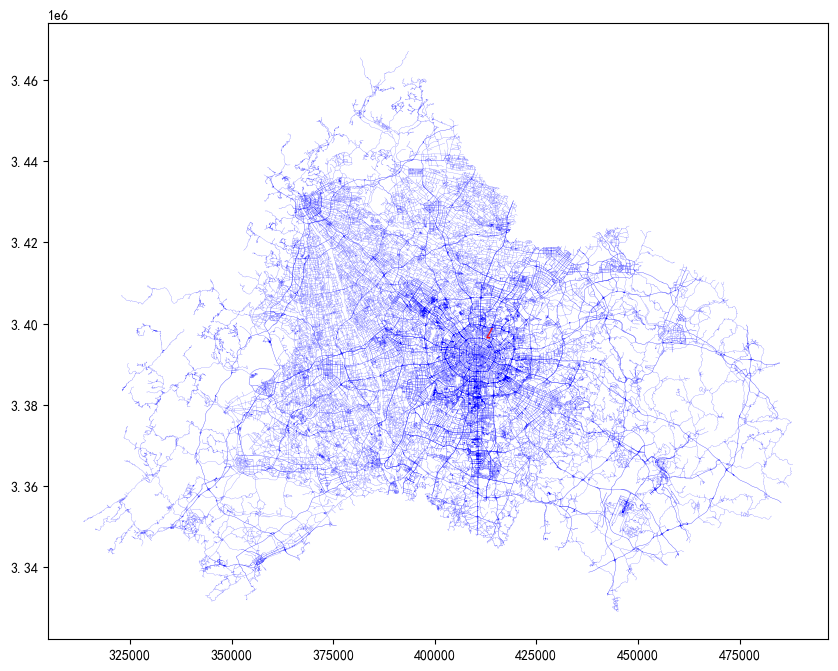

In [315]:
fig, ax = plt.subplots(1,1,figsize=(12, 8)) # 可使用GridSpec用法
# cd.plot(ax=ax,column='NAME',legend=True,alpha=0.5,cmap='tab20')
road.plot(ax=ax,color='blue',alpha=0.5,linewidth=0.2)
get_path(path=short_path,road=road).plot(ax=ax,color='red',linewidth=1)
plt.show()

In [208]:
trip_data['osmid_D'] = quanxin['osmid']

In [43]:
bike_use_time = trip_data.groupby(by='bikeid',as_index=False).agg({'duration':'sum'})
bike_use_time['use_time_perc'] = bike_use_time['duration'] / (24*60)

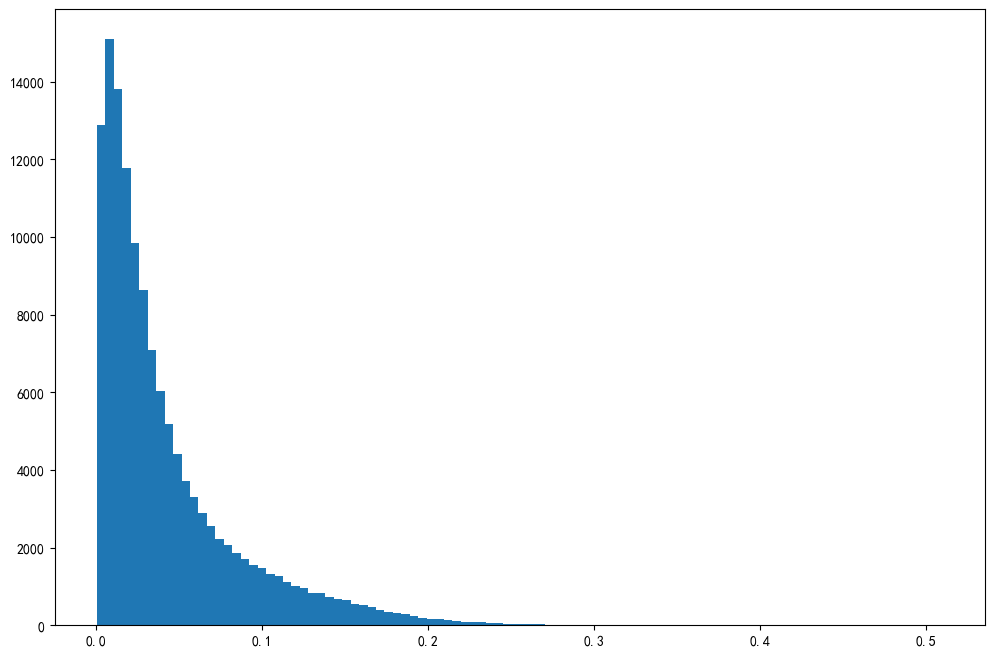

In [51]:
fig, ax = plt.subplots(1,1,figsize=(12, 8)) # 可使用GridSpec用法
ax.hist(bike_use_time['use_time_perc'],bins=100)
plt.show()

In [6]:
trip_data['starttime1'] = trip_data['starttime'].shift(-1)
trip_data['startlng1'] = trip_data['startlng'].shift(-1)
trip_data['startlat1'] = trip_data['startlat'].shift(-1)
trip_data['bikeid1'] = trip_data['bikeid'].shift(-1)

trip_data = trip_data.drop(trip_data[trip_data['bikeid']!=trip_data['bikeid1']].index)

#考虑GPS漂移和车辆再平衡
trip_data['distance']=trip_data.apply(lambda x:tbd.getdistance(x['endlng'], x['endlat'], x['startlng1'], x['startlat1'])/1000,axis=1)

# part_data 表示停放数据
park_data = trip_data[['bikeid','endtime','endlng','endlat','starttime1','startlng1','startlat1','distance']]

park_data.rename(columns={'endtime':'park_starttime','endlng':'startlng','endlat':'startlat','starttime1':'park_endtime','startlng1':'endlng','startlat1':'endlat'},inplace=True)

In [31]:
# park_data = pd.DataFrame(columns=['bikeid','endtime','endlng','endlat','starttime1','startlng1','startlat1'])
# for bike_id in tqdm(bike_id_array):
#     temp_data = trip_data[trip_data['bikeid']==bike_id].sort_values(by=['starttime'])
#     if len(temp_data)>1:
#         temp_data['starttime1'] = temp_data['starttime'].shift(-1)
#         temp_data['startlng1'] = temp_data['startlng'].shift(-1)
#         temp_data['startlat1'] = temp_data['startlat'].shift(-1)
#         #考虑GPS漂移和车辆再平衡
#         # temp_data['distance']=temp_data.apply(lambda x:tbd.getdistance(x['endlng'], x['endlat'], x['startlng1'], x['startlat1']),axis=1)
#         #数据上移后最后一行数据会出现空值，删除最后一行数据
#         #temp_data.drop(temp_data.tail(1).index,inplace=True) 
#         temp_park_data = temp_data[['bikeid','endtime','endlng','endlat','starttime1','startlng1','startlat1']]
#         park_data = np.concatenate([park_data,temp_park_data])
        